In [2]:
import yfinance as yf
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math


In [3]:
ticker = "AAPL"
start_date = "2010-01-01"
end_date = datetime.datetime.now().strftime("%Y-%m-%d")

data = yf.download(ticker, start=start_date, end=end_date)
close_prices = data['Close']
log_returns= np.log(close_prices / close_prices.shift(1))
mean_estimate = log_returns.mean()
variance_estimate = log_returns.var()
print("Overall Mean Estimate (log returns):", mean_estimate)
print("Overall Realized Variance Estimate (log returns):", variance_estimate)
data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Overall Mean Estimate (log returns): Ticker
AAPL    0.000886
dtype: float64
Overall Realized Variance Estimate (log returns): Ticker
AAPL    0.00032
dtype: float64


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.440332,6.455078,6.391280,6.422878,493729600
2010-01-05,6.451468,6.487881,6.417461,6.458088,601904800
2010-01-06,6.348846,6.477045,6.342225,6.451465,552160000
2010-01-07,6.337110,6.379843,6.291067,6.372319,477131200
2010-01-08,6.379241,6.379843,6.291368,6.328683,447610800
...,...,...,...,...,...
2025-04-10,190.419998,194.779999,183.000000,189.070007,121880000
2025-04-11,198.149994,199.539993,186.059998,186.100006,87435900


In [4]:
window_size = 252

# Compute rolling mean and rolling variance of the log returns
rolling_mean = log_returns.rolling(window=window_size).mean()
rolling_variance = log_returns.rolling(window=window_size).var()

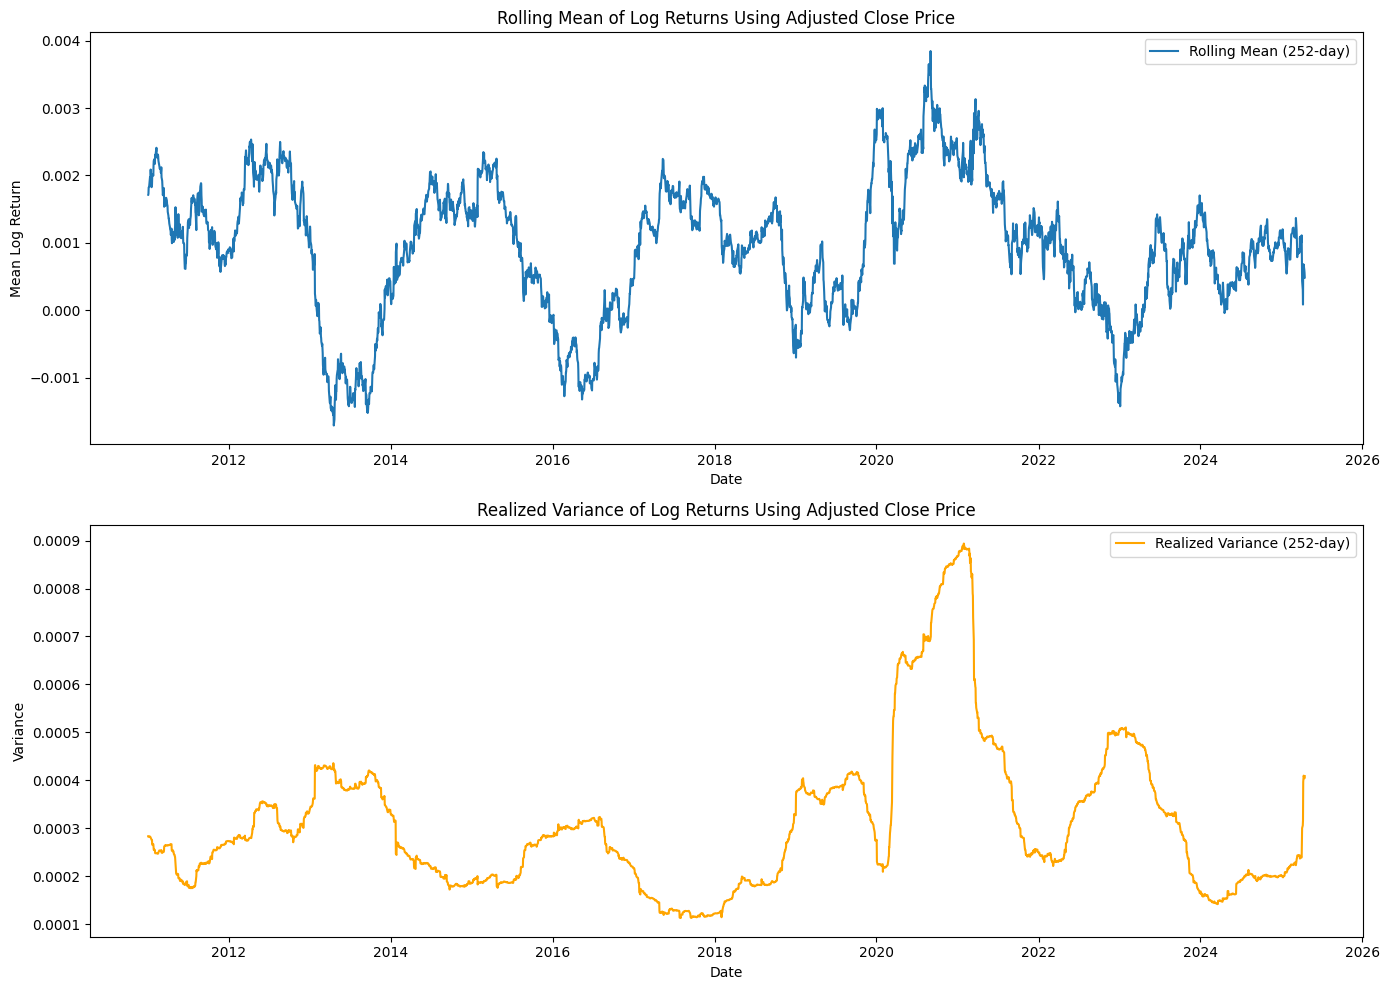

In [5]:
# Plot the rolling estimators
plt.figure(figsize=(14, 10))

# Plot rolling mean
plt.subplot(2, 1, 1)
plt.plot(rolling_mean, label="Rolling Mean (252-day)")
plt.title("Rolling Mean of Log Returns Using Adjusted Close Price")
plt.xlabel("Date")
plt.ylabel("Mean Log Return")
plt.legend()

# Plot realized variance (rolling variance)
plt.subplot(2, 1, 2)
plt.plot(rolling_variance, label="Realized Variance (252-day)", color='orange')
plt.title("Realized Variance of Log Returns Using Adjusted Close Price")
plt.xlabel("Date")
plt.ylabel("Variance")
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
def historical_mean_strict(close):
    n = len(close)
    delta_t = 1
    mu = 0
    for i in range(n - 1):
        mu += (1 / delta_t) * (close[i + 1] - close[i]) / close[i]
    mu = mu / n
    return mu

In [7]:
def historical_var_strict(close):
    n = len(close)
    delta_t = 1
    sigma = 0
    for j in range(n - 1):
        sigma += (1 / delta_t) * ((close[j + 1] - close[j]) / close[j])**2
    mu = historical_mean_strict(close)
    sigma = (1 / (n - 1)) * sigma - (n / (n - 1)) * mu**2
    sigma = np.sqrt(sigma)
    return sigma


In [8]:
# Calculate the historical mean and variance using strict method
historical_mean = historical_mean_strict(close_prices.values)  
historical_variance = historical_var_strict(close_prices.values)
print("Historical Mean (strict method):", historical_mean)
print("Historical Variance (strict method):", historical_variance)

Historical Mean (strict method): [0.0010459]
Historical Variance (strict method): [0.01787896]


In [14]:
def parkinson_volatility_estimator(data):
    """
    Calculate the Parkinson volatility estimator for the given close prices.
    """
    log_ranges = np.log(data["High"] / data["Low"]) ** 2
    sum_log_ranges = log_ranges.sum()
    parkinson_daily = math.sqrt((1.0 / (4.0 * len(data) * math.log(2))) * sum_log_ranges)
    return parkinson_daily
# Calculate the Parkinson volatility estimator
parkinson_volatility = parkinson_volatility_estimator(data)
print("Parkinson Volatility Estimator:", parkinson_volatility)  


Parkinson Volatility Estimator: 0.01416852672896428


/var/folders/bz/l0ll5lm149nb9t8fpqqq0lbm0000gn/T/ipykernel_48516/4089986607.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  parkinson_daily = math.sqrt((1.0 / (4.0 * len(data) * math.log(2))) * sum_log_ranges)


/var/folders/bz/l0ll5lm149nb9t8fpqqq0lbm0000gn/T/ipykernel_48516/678642260.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu += (1 / delta_t) * (close[i + 1] - close[i]) / close[i]


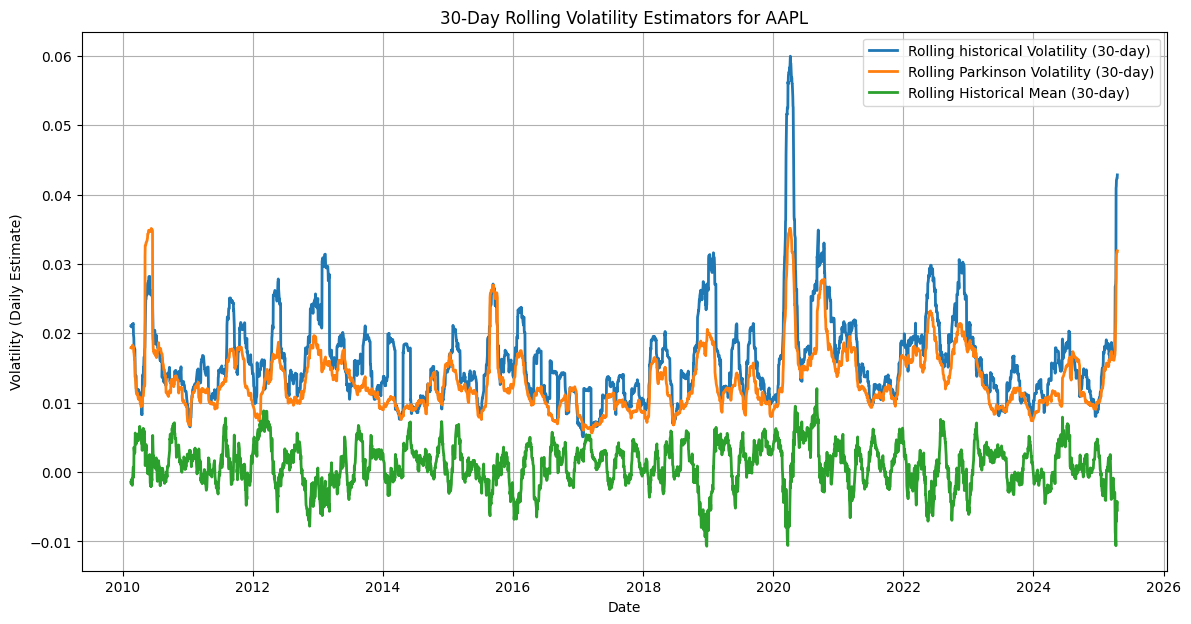

In [17]:
window_size = 30
# Calculate the Parkinson volatility estimator for rolling windows
#rolling_parkinson_volatility = data.rolling(window=window_size).apply(parkinson_volatility_estimator, raw=False)
log_ranges = np.log(data["High"] / data["Low"])**2
roll_sum = log_ranges.rolling(window=window_size).sum()
rolling_parkinson_volatility = np.sqrt( roll_sum / (4 * window_size * np.log(2)) )
#Calculate the rolling historical mean and variance
rolling_historical_mean = close_prices.rolling(window=window_size).apply(historical_mean_strict, raw=False) 
rolling_historical_variance = close_prices.rolling(window=window_size).apply(historical_var_strict, raw=False)
plt.figure(figsize=(14, 7))
plt.plot(rolling_historical_variance, label='Rolling historical Volatility (30-day)', lw=2)
plt.plot(rolling_parkinson_volatility, label='Rolling Parkinson Volatility (30-day)', lw=2)
plt.plot(rolling_historical_mean, label='Rolling Historical Mean (30-day)', lw=2)
plt.title(f'30-Day Rolling Volatility Estimators for {ticker}')
plt.xlabel('Date')
plt.ylabel('Volatility (Daily Estimate)')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
import pandas as pd
from skfolio.datasets import load_sp500_dataset, load_sp500_implied_vol_dataset
from skfolio.preprocessing import prices_to_returns

In [23]:
data.reset_index(inplace=True)
data["Return"] = np.log(data["Close"] / data["Close"].shift(1))
data["Avg Return"] = data["Return"].expanding().mean()
data["Daily Volatility"] = data["Return"].expanding().var()
close_all = data['Close'].values
dates_all = data['Date'].values
def windowfunction(window):
    rolling_mu = []
    rolling_sigma = []
    rolling_dates = []

    for i in range(window, len(close_all)):
        window_close = close_all[i - window:i + 1]
        mu = historical_mean_strict(window_close)
        sigma = historical_var_strict(window_close)
        rolling_mu.append(mu)
        rolling_sigma.append(sigma)
        rolling_dates.append(dates_all[i])

    return rolling_dates,rolling_mu,rolling_sigma

In [24]:
prices = load_sp500_dataset()
implied_vol = load_sp500_implied_vol_dataset()

prices_aapl = prices["AAPL"].loc["2010":]
iv_aapl = implied_vol["AAPL"].loc["2010":]
rolling_dates,_,realized_vol = windowfunction(30)
rv_series = pd.Series(realized_vol, index=rolling_dates)

# 合并成一个 DataFrame
df = pd.DataFrame({
     "Realized Variance (30d)": rv_series,
     "Implied Volatility (approx daily var)": (iv_aapl/np.sqrt(252))
}).dropna()

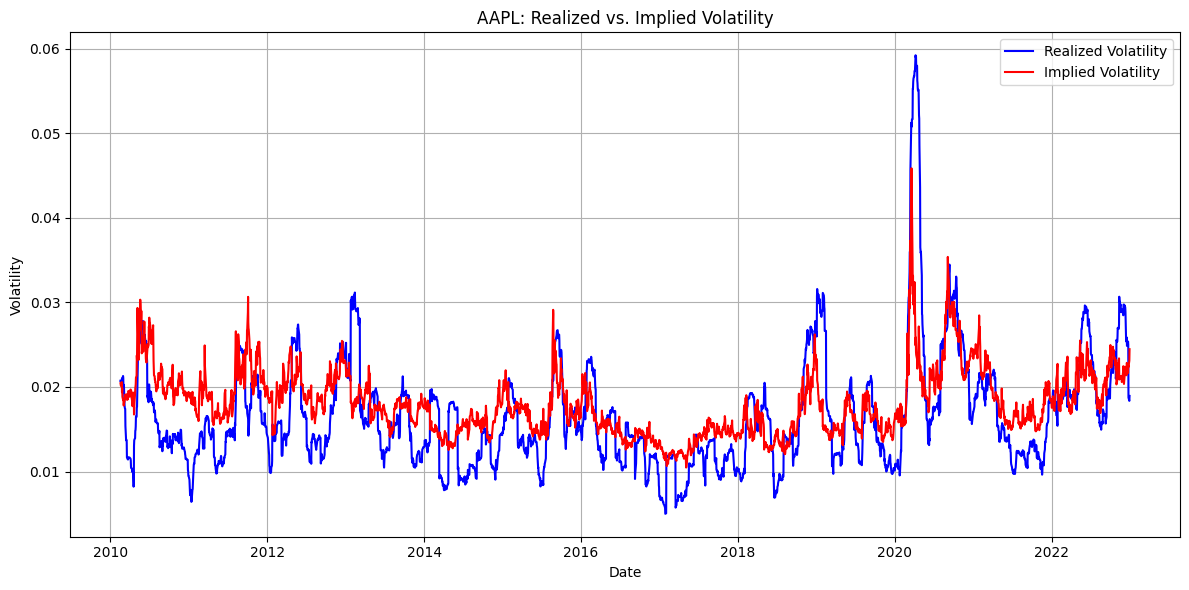

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Realized Variance (30d)"], label="Realized Volatility", color='blue')
plt.plot(df.index, df["Implied Volatility (approx daily var)"], label="Implied Volatility", color='red')
plt.title("AAPL: Realized vs. Implied Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
spx_symbol = "^SPX"
today = "2025-04-08"
end_date = pd.to_datetime(today)
start_date=end_date-datetime.timedelta(days=365)

spx_data=yf.download(spx_symbol,start_date,end_date)
lastBusDay=spx_data.index[-1]
vix_data=yf.download("^VIX",start=lastBusDay,end=lastBusDay+datetime.timedelta(days=1))
S0 = float(spx_data["Close"].iloc[-1])
r = 0.02  # assume a flat 2% annual risk‑free rate
T = 1/12  # for example, if you want a one‑month forward; you need to define T yourself
F0 = S0 * math.exp(r * T)



[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
/var/folders/bz/l0ll5lm149nb9t8fpqqq0lbm0000gn/T/ipykernel_48516/2199865286.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(spx_data["Close"].iloc[-1])


In [27]:
spx_ticker=yf.Ticker("^SPX")
expiry_date="2025-05-08"
chain=spx_ticker.option_chain(expiry_date)
calls_df=chain.calls
puts_df=chain.puts

print("Calls Head:")
print(calls_df.head())

print("Puts Head:")
print(puts_df.head())

Calls Head:
        contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0  SPXW250508C02400000 2025-04-01 19:43:32+00:00  2400.0    3227.91  2867.3   
1  SPXW250508C03600000 2025-04-07 09:48:18+00:00  3600.0    1358.50  1677.8   
2  SPXW250508C04600000 2025-04-07 01:13:52+00:00  4600.0     494.90   696.8   
3  SPXW250508C04875000 2025-04-09 15:04:42+00:00  4875.0     314.30   444.0   
4  SPXW250508C04900000 2025-04-09 14:32:24+00:00  4900.0     324.90   422.3   

      ask  change  percentChange  volume  openInterest  impliedVolatility  \
0  2885.4     0.0            0.0     7.0          17.0           0.000010   
1  1684.7     0.0            0.0     NaN           5.0           0.000010   
2   704.3     0.0            0.0     NaN           5.0           0.335288   
3   450.7     0.0            0.0     NaN           6.0           0.315688   
4   429.0     0.0            0.0     2.0          23.0           0.313461   

   inTheMoney contractSize currency  
0        Tru

In [30]:
calls_df.to_csv("spx_call.csv",index=False)
puts_df.to_csv("spx_puts.csv",index=False)

In [41]:
tau=30/365
r=0.05
calls_df['midPrice'] = (calls_df['bid'] + calls_df['ask']) / 2
puts_df['midPrice'] = (puts_df['bid'] + puts_df['ask']) / 2

CallandPuts = pd.merge(
    calls_df[['strike', 'midPrice']],
    puts_df[['strike', 'midPrice']],
    on='strike',
    suffixes=('_call', '_put')
)
CallandPuts['abs_diff'] = np.abs(CallandPuts['midPrice_call'] - CallandPuts['midPrice_put'])
F_strike=CallandPuts.loc[CallandPuts['abs_diff'].idxmin(),'strike']

puts=CallandPuts[CallandPuts['strike']<F_strike]
calls=CallandPuts[CallandPuts['strike']>F_strike]
dK_puts=np.diff(puts['strike'])
dK_calls=np.diff(calls['strike'])
int_puts=np.sum((puts['midPrice_put'].values[:-1]/(puts['strike'].values[:-1]**2))*dK_puts)
int_calls=np.sum((calls['midPrice_call'].values[:-1]/(calls['strike'].values[:-1]**2))*dK_calls)

vix_est_squared=(2*np.exp(r*tau)/tau)*(int_puts+int_calls)
vix_est=np.sqrt(vix_est_squared)

print(vix_est*100,vix_data['Close'])

25.27137275698343 Ticker       ^VIX
Date             
2025-04-07  46.98


In [33]:
vix_hist = yf.download("^VIX", start="2010-01-01", end="2025-04-08")["Close"]
rolling_dates,_,realized_vol = windowfunction(30)
rv_series = pd.Series(realized_vol, index=pd.to_datetime(rolling_dates), name="Realized_Var")
realized_var = rv_series ** 2*252
vix_series = pd.Series((vix_hist / 100).squeeze(), index=vix_hist.index, name="VIX")
df_rvandvix = pd.concat([realized_var, vix_series], axis=1).dropna()


[*********************100%***********************]  1 of 1 completed


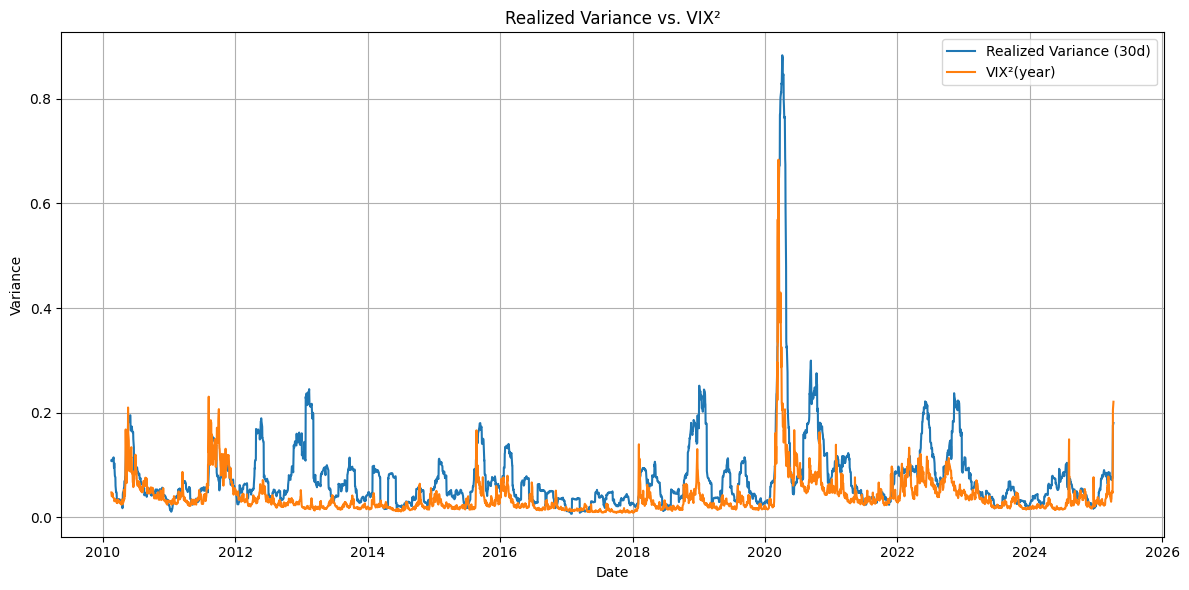

Correlation：0.641


In [34]:
plt.figure(figsize=(12, 6))
plt.plot(df_rvandvix.index, df_rvandvix["Realized_Var"], label="Realized Variance (30d)")
plt.plot(df_rvandvix.index, df_rvandvix["VIX"]**2, label="VIX²(year)")
plt.title("Realized Variance vs. VIX²")
plt.xlabel("Date")
plt.ylabel("Variance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
corr = df_rvandvix["Realized_Var"].corr(df_rvandvix["VIX"])
print(f"Correlation：{corr:.3f}")

In [54]:
import statsmodels.api as sm

prices=load_sp500_dataset()
implied_vol=load_sp500_implied_vol_dataset()
X=prices_to_returns(prices)
X=X.loc["2010":]
implied_vol.tail()
ticker = "AAPL"
returns = X[ticker]
sp500_returns = pd.Series(returns.squeeze(), index=returns.index, name="SPX")
df_SPXandVIX = pd.concat([sp500_returns, vix_series], axis=1).dropna().astype(float)
df_SPXandRV = pd.concat([sp500_returns, rv_series], axis=1).dropna().astype(float)

X_vix = sm.add_constant(df_SPXandVIX["SPX"])
X_rv = sm.add_constant(df_SPXandRV["SPX"])
model_vix = sm.OLS(df_SPXandVIX["VIX"], X_vix).fit()
model_rv = sm.OLS(df_SPXandRV["Realized_Var"], X_rv).fit()
print("=== VIX Regression result ===")
print(model_vix.summary())


=== VIX Regression result ===
                            OLS Regression Results                            
Dep. Variable:                    VIX   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     41.07
Date:                Thu, 17 Apr 2025   Prob (F-statistic):           1.68e-10
Time:                        19:17:31   Log-Likelihood:                 3934.3
No. Observations:                3270   AIC:                            -7865.
Df Residuals:                    3268   BIC:                            -7852.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1875 

In [55]:
print("\n=== Realized Var Regression result ===")
print(model_rv.summary())


=== Realized Var Regression result ===
                            OLS Regression Results                            
Dep. Variable:           Realized_Var   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1302
Date:                Thu, 17 Apr 2025   Prob (F-statistic):              0.718
Time:                        19:17:32   Log-Likelihood:                 11643.
No. Observations:                3240   AIC:                        -2.328e+04
Df Residuals:                    3238   BIC:                        -2.327e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       